In [ ]:
import numpy as np
from itertools import cycle

In [ ]:
hx_cons_data= np.load('/content/drive/MyDrive/Didar Hussain /Alternative Splicing/High inclusion data/x_cons_data.npy')
hx_cas_data= np.load('/content/drive/MyDrive/Didar Hussain /Alternative Splicing/High inclusion data/x_cas_data.npy')
lx_cas_data= np.load('/content/drive/MyDrive/Didar Hussain /Alternative Splicing/low inclusion data/x_cas_data.npy')

In [ ]:
hx_cons_data.shape,hx_cas_data.shape,lx_cas_data.shape

((39128, 283, 5), (4952, 283, 5), (6838, 283, 5))

In [ ]:
auccc=np.zeros((10,10))

In [ ]:
def cross_split(x_cons_data,hx_cas_data,lxcase_data,s):

    a=int(x_cons_data.shape[0]/10)
    b=int(hx_cas_data.shape[0]/10)
    c=int(lx_cas_data.shape[0]/10)

    #9 folds for training
    train=x_cons_data[:a*s]
    train=np.concatenate((train,x_cons_data[a*(s+1):]),axis=0)

    d=int((9*a)/(9*(b+c)))
    print(d)
    for i in range (d):
        train=np.concatenate((train,hx_cas_data[:b*s]),axis=0)
        train=np.concatenate((train,hx_cas_data[b*(s+1):]),axis=0)

        train=np.concatenate((train,lx_cas_data[:c*s]),axis=0)
        train=np.concatenate((train,lx_cas_data[c*(s+1):]),axis=0)

    np.random.shuffle(train)
    np.random.shuffle(train)

    # 1 fold for testing

    htest=np.concatenate((hx_cas_data[b*s:b*(s+1)],x_cons_data[a*s:a*(s+1)]),axis=0)
    lt=   np.concatenate((lx_cas_data[c*s:c*(s+1)],x_cons_data[a*s:a*(s+1)]),axis=0)

    test=htest
    test=np.concatenate((test,lx_cas_data[c*s:c*(s+1)]),axis=0)

    cons_test=x_cons_data[a*s:a*(s+1)]
    cas_test=np.concatenate((lx_cas_data[c*s:c*(s+1)],hx_cas_data[b*s:b*(s+1)]))

    return train,test,htest,lt,cons_test,cas_test

In [ ]:
l=141

In [ ]:
train,test,htest,ltest,cons,cas=cross_split(hx_cons_data,hx_cas_data,lx_cas_data,5)

y_train=train[:,l-1,0]
y_test=test[:,l-1,0]
hy_test=htest[:,l-1,0]
ly_test=ltest[:,l-1,0]

train.shape,test.shape,htest.shape

3


((67052, 283, 5), (5090, 283, 5), (4407, 283, 5))

In [ ]:
def evaluate_AUC2():
    psi=cas[:,-1,4]
    roc_auc=np.zeros(5)
    colors = cycle(['black','green','red','orange','blue'])
    f=plt.figure()


    for i, color in zip(range(5), colors):


        ptest=cas[ (psi >=i*2*0.1) & (psi< (i+1)*2*0.1)  ]
        ptest=np.concatenate((ptest,cons),axis=0)
        py_test=ptest[:,l-1,0]

        ypreds=model.predict([ptest[:,:l-1,:4],ptest[:,l:(l*2)-1,:4],ptest[:,-1,0:3]])
        fpr, tpr, thresholds = roc_curve(py_test, ypreds)
        roc_auc[i] = auc(fpr, tpr)
        lw=2

        plt.plot(fpr, tpr, color=color, lw=lw,
                 label='Inclusion level %d-%d %% (AUC= %0.2f)' % (i*2*10,(i+1)*2*10,roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    f.savefig("../plots/cas2.pdf", bbox_inches='tight')
    plt.show()

    roc_auc=np.zeros(10)

    for i in range(10):
            ptest=cas[(psi >=i*0.1) & (psi< (i+1)*0.1)]
            ptest=np.concatenate((ptest,cons),axis=0)
            py_test=ptest[:,l-1,0]

            ypreds=model.predict([ptest[:,:l-1,:4],ptest[:,l:(l*2)-1,:4],ptest[:,-1,0:3]])
            fpr, tpr, thresholds = roc_curve(py_test, ypreds)
            roc_auc[i] = auc(fpr, tpr)


    return roc_auc

In [ ]:
def evaluate_AUC():
    ypreds=model.predict([htest[:,:l-1,:4],htest[:,l:(l*2)-1,:4],htest[:,-1,0:3]])
    fpr, tpr, thresholds = roc_curve(hy_test, ypreds)
    roc_auc = auc(fpr, tpr)

    ypreds2=model.predict([test[:,:l-1,:4],test[:,l:(l*2)-1,:4],test[:,-1,0:3]])
    fpr2, tpr2, thresholds2 = roc_curve(y_test, ypreds2)
    roc_auc2 = auc(fpr2, tpr2)

    ypreds3=model.predict([ltest[:,:l-1,:4],ltest[:,l:(l*2)-1,:4],ltest[:,-1,0:3]])
    fpr3, tpr3, thresholds3 = roc_curve(ly_test, ypreds3)
    roc_auc3 = auc(fpr3, tpr3)


    lw=2



    f=plt.figure()
    plt.plot(fpr2, tpr2, color='orange', lw=1, label=    'All ES events (AUC= %0.2f)' % roc_auc2)

    plt.plot(fpr, tpr, color='red', lw=1,          label='HEvents ES subset (AUC= %0.2f)' % roc_auc)

    plt.plot(fpr3, tpr3, color='navy', lw=1,       label='MREvents ES subset (AUC= %0.2f)' % roc_auc3)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    f.savefig("../plots/cas.pdf", bbox_inches='tight')

    plt.show()


    return

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
import keras.optimizers
from tensorflow.keras.optimizers import SGD
from keras.layers import Bidirectional, TimeDistributed
from keras import regularizers
from keras import optimizers
from keras.layers import Input, BatchNormalization
from keras.models import Model
from sklearn import metrics
import tensorflow as tf

In [ ]:
from keras import regularizers

In [ ]:
from keras import regularizers
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from keras import initializers
from keras.layers import Activation, Dense, Add

In [ ]:
aucc=np.zeros((10,3))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 140, 4)]     0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 140, 4)]     0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 134, 8)       232         ['input_8[0][0]']                
                                                                                                  
 conv1d_17 (Conv1D)             (None, 134, 8)       232         ['input_7[0][0]']                
                                                                                            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None


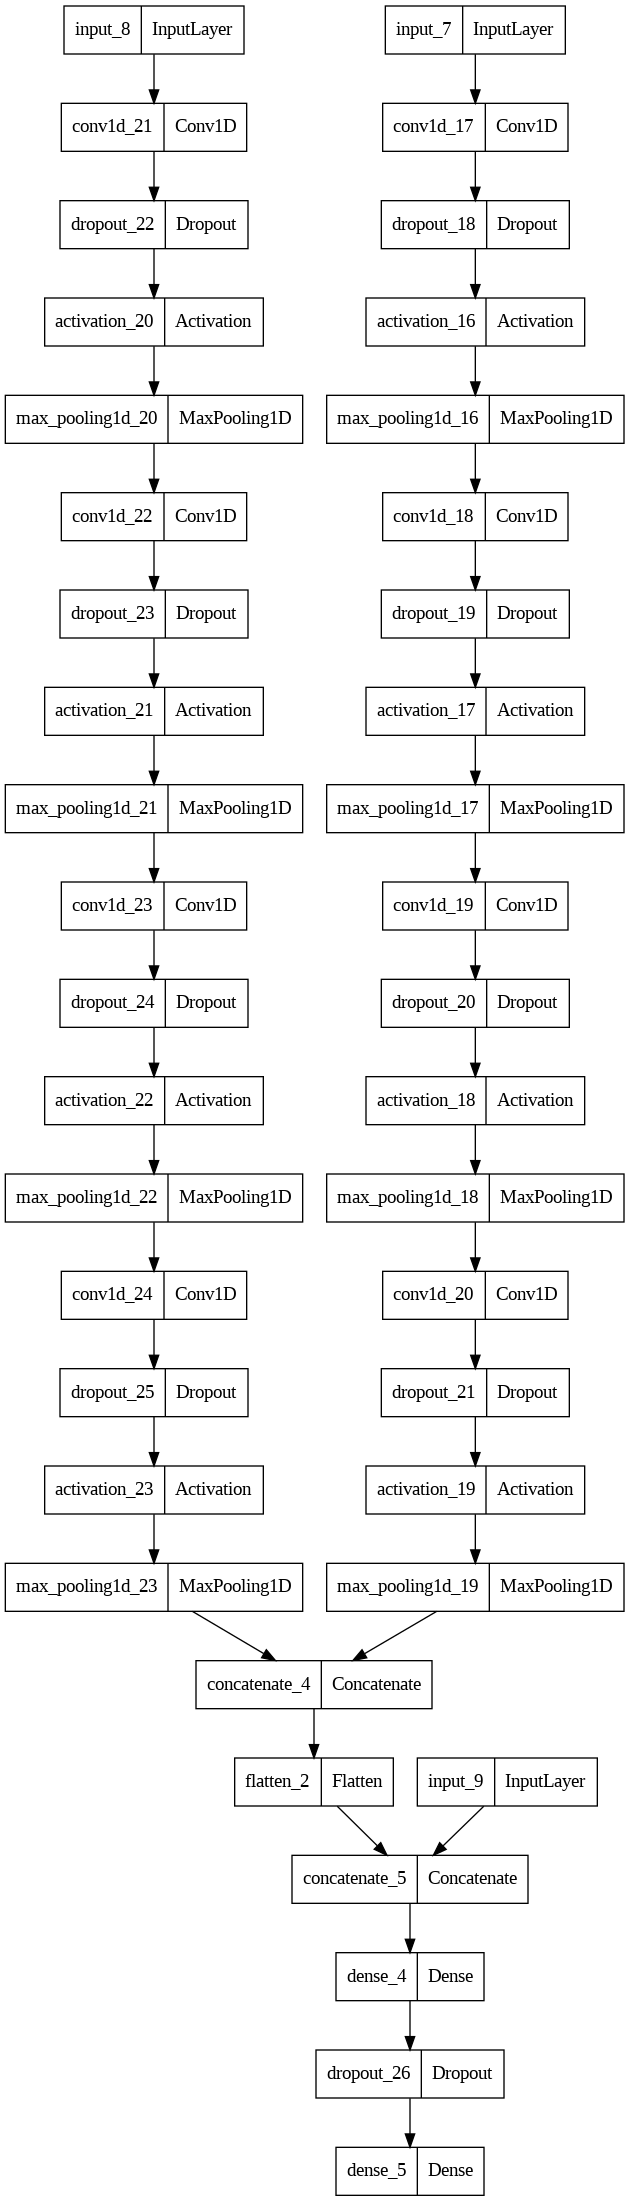

In [ ]:
inputs1 = Input(shape=(l-1, 4))
inputs2 = Input(shape=(l-1, 4))
inputs3 = Input(shape=(3,))

x=Conv1D(filters=8,kernel_size=7,strides=1,kernel_initializer=initializers.random_uniform()) (inputs1)
x=Dropout(0.2)(x)
x=Activation('relu')(x)
x=MaxPooling1D(pool_size=2, strides=2)(x)

x=Conv1D(filters=16,kernel_size=4,strides=1,kernel_initializer=initializers.random_uniform()) (x)
x=Dropout(0.2)(x)
x=Activation('relu')(x)
x=MaxPooling1D(pool_size=2, strides=2)(x)

x=Conv1D(filters=32,kernel_size=3,strides=1,kernel_initializer=initializers.random_uniform()) (x)
x=Dropout(0.2)(x)
x=Activation('relu')(x)
x=MaxPooling1D(pool_size=2, strides=2)(x)

x=Conv1D(filters=64,kernel_size=2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
x=Dropout(0.2)(x)
x=Activation('relu')(x)
x=MaxPooling1D(pool_size=2, strides=2)(x)


xx=Conv1D(filters=8,kernel_size=7,strides=1,kernel_initializer=initializers.random_uniform()) (inputs2)
xx=Dropout(0.2)(xx)
xx=Activation('relu')(xx)
xx=MaxPooling1D(pool_size=2, strides=2)(xx)

xx=Conv1D(filters=16,kernel_size=4,strides=1,kernel_initializer=initializers.random_uniform()) (xx)
xx=Dropout(0.2)(xx)
xx=Activation('relu')(xx)
xx=MaxPooling1D(pool_size=2, strides=2)(xx)

xx=Conv1D(filters=32,kernel_size=3,strides=1,kernel_initializer=initializers.random_uniform()) (xx)
xx=Dropout(0.2)(xx)
xx=Activation('relu')(xx)
xx=MaxPooling1D(pool_size=2, strides=2)(xx)

xx=Conv1D(filters=64,kernel_size=2,strides=1,kernel_initializer=initializers.random_uniform()) (xx)
xx=Dropout(0.2)(xx)
xx=Activation('relu')(xx)
xx=MaxPooling1D(pool_size=2, strides=2)(xx)

x2=keras.layers.concatenate([xx,x])

x2=Flatten()(x2)

x2=keras.layers.concatenate([x2,inputs3],axis=1)


x3=Dense(1024, activation='relu',)(x2)
x3=Dropout(0.5)(x3)


#Output Layer
x3=Dense(1, activation='sigmoid',)(x3)      #Normal CNN
#x3=Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='linear')(x3)   #SVM


model = Model(inputs=[inputs1,inputs2,inputs3], outputs=x3)


import tensorflow
#loss='binary_crossentropy' replace with hinge to make SVM, gini indix to make DT
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.0005,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0),metrics=['accuracy'])

print(model.summary())
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_w2.png')

In [ ]:
for i in range (10):



    print('epoch :',i)
    model.fit([train[:,:l-1,:4],train[:,l:(l*2)-1,:4],train[:,-1,0:3]], y_train,validation_data=([test[:,:l-1,:4],test[:,l:(l*2)-1,:4],test[:,-1,0:3]], y_test), epochs =1, verbose = 1, batch_size = 256)
    y_=model.predict([htest[:,:l-1,:4],htest[:,l:(l*2)-1,:4],htest[:,-1,0:3]])
    print("AUC under ROC for high inclusion exons:",roc_auc_score(hy_test, y_))

epoch : 0
138/138 [==============================] - 1s 4ms/step
AUC under ROC for high inclusion exons: 0.6286778831257359
epoch : 1
138/138 [==============================] - 2s 10ms/step
AUC under ROC for high inclusion exons: 0.6956383879696764
epoch : 2
138/138 [==============================] - 0s 3ms/step
AUC under ROC for high inclusion exons: 0.7283602900167317
epoch : 3
138/138 [==============================] - 0s 3ms/step
AUC under ROC for high inclusion exons: 0.7618392514098036
epoch : 4
138/138 [==============================] - 1s 4ms/step
AUC under ROC for high inclusion exons: 0.769433599801698
epoch : 5
138/138 [==============================] - 1s 4ms/step
AUC under ROC for high inclusion exons: 0.787779120447832
epoch : 6
138/138 [==============================] - 0s 3ms/step
AUC under ROC for high inclusion exons: 0.7913588853772904
epoch : 7
138/138 [==============================] - 1s 4ms/step
AUC under ROC for high inclusion exons: 0.7892772303815249
epoch : 8

In [ ]:
y1_=model.predict([htest[:,:l-1,:4],htest[:,l:(l*2)-1,:4],htest[:,-1,0:3]])
ac1 = roc_auc_score(hy_test, y1_)

y2_=model.predict([ltest[:,:l-1,:4],ltest[:,l:(l*2)-1,:4],ltest[:,-1,0:3]])
ac3 = roc_auc_score(ly_test, y2_)

y_=model.predict([test[:,:l-1,:4],test[:,l:(l*2)-1,:4],test[:,-1,0:3]])
ac2 = roc_auc_score(y_test, y_)
ac1,ac3,ac2

160/160 [==============================] - 1s 4ms/step


(0.797411745264506, 0.8807747382383146, 0.8457452972179111)

144/144 [==============================] - 1s 3ms/step


FileNotFoundError: ignored

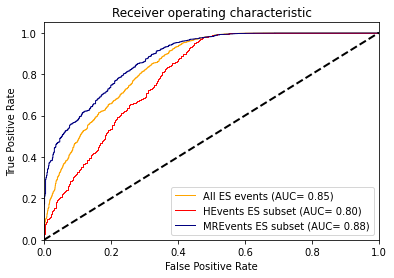

In [ ]:
evaluate_AUC()

138/138 [==============================] - 0s 3ms/step


FileNotFoundError: ignored

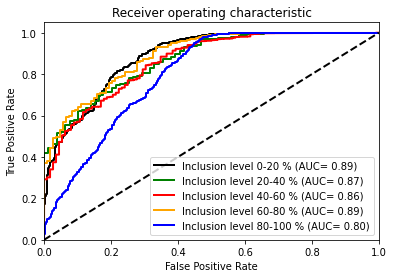

In [ ]:
evaluate_AUC2()